In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset = {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
       'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
       'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
       'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}

In [3]:
df = pd.DataFrame(dataset,columns=['Taste','Temperature','Texture','Eat'])

In [4]:
df

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


In [95]:
feat_cols = df.drop('Eat', axis=1).columns
label_col = 'Eat'

In [92]:
def entropy_all_data(data, label_col):
    num_yes = len(data[data[label_col]=='Yes'])
    num_no = len(data[data[label_col]=='No'])
    num_all = len(data)
    p_yes = -(num_yes/num_all) * np.log2(num_yes/num_all)
    p_no = -(num_no/num_all) * np.log2(num_no/num_all)
    return p_yes + p_no

In [96]:
H = entropy_all_data(df, label_col)

In [97]:
H

0.9709505944546686

In [99]:
def simple_gain(data, feat_cols, label_col):
    all_e = {}
    for column in df[feat_cols].columns:
        uniques = data[column].unique()
        for unique in uniques:
            num_yes = len(df[(df[column] == unique) & (df[label_col] == 'Yes')])
            num_no = len(df[(df[column] == unique) & (df[label_col] == 'No')])
            num_all = len(df[(df[column] == unique)])
            if num_yes == 0:
                e_yes = 0
            else:
                e_yes = -(num_yes/num_all) * np.log2(num_yes/num_all)
            if num_no == 0:
                e_no = 0
            else:
                e_no = -(num_no/num_all) * np.log2(num_no/num_all)
            all_e[column+'_'+unique] = e_yes + e_no
    return all_e

In [101]:
E_dict = simple_gain(df, feat_cols, label_col)

In [102]:
E_dict

{'Taste_Salty': 0.9182958340544896,
 'Taste_Spicy': 0.9709505944546686,
 'Taste_Sweet': 0.0,
 'Temperature_Hot': 0.9182958340544896,
 'Temperature_Cold': 1.0,
 'Texture_Soft': 1.0,
 'Texture_Hard': 0.8112781244591328}

In [217]:
def final_gain(data, feat_cols, label_col, E_dict, H):
    all_gains = []
    num_all = len(data)
    for column in df[feat_cols].columns:
        gains_columns = []
        uniques = data[column].unique()
        for unique in uniques:
            num_elements = len(df[(df[column] == unique)])
            gain = num_elements/num_all * E_dict[column+'_'+unique]
            gains_columns.append(gain)
        all_gains.append(H - np.sum(gains_columns))
    return all_gains

In [218]:
gain = final_gain(df, feat_cols, label_col, E_dict, H)

In [219]:
gain

[0.2099865470109874, 0.01997309402197489, 0.0464393446710154]

In [220]:
print("Best feature:", feat_cols[np.argmax(gain)])
print("Gain:", np.max(gain))

Best feature: Taste
Gain: 0.2099865470109874


# SKLEARN

In [165]:
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [168]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
taste_encoded = le.fit_transform(df['Taste'])
temp_encoded = le.fit_transform(df['Temperature'])
text_encoded = le.fit_transform(df['Texture'])
eat_encoded = le.fit_transform(df['Eat'])

In [192]:
merged = np.vstack([taste_encoded, temp_encoded, text_encoded, eat_encoded]).T

In [193]:
merged

array([[0, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 1],
       [2, 0, 1, 1],
       [0, 0, 1, 0],
       [2, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 0, 1]])

In [195]:
merged_df = pd.DataFrame(merged, columns=df.columns)

In [196]:
merged_df

,Taste,Temperature,Texture,Eat
0,0,1,1,0
1,1,1,1,0
2,1,1,0,1
3,1,0,0,0
4,1,1,0,1
5,2,0,1,1
6,0,0,1,0
7,2,1,1,1
8,1,0,1,1
9,0,1,0,1


In [209]:
tree_model = DecisionTreeClassifier(criterion='entropy')
tree_model.fit(merged_df.drop('Eat', axis=1), merged_df['Eat'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

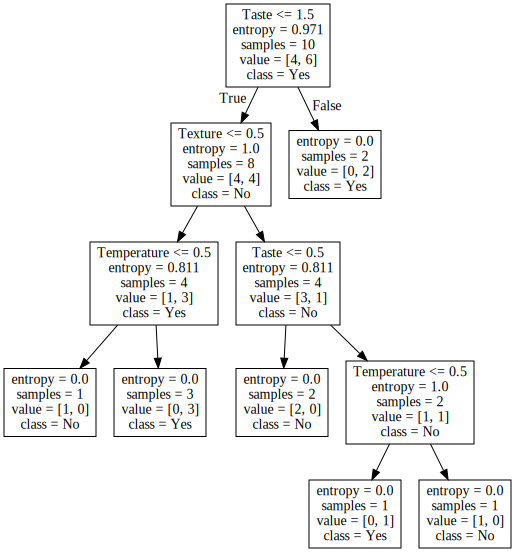

In [210]:
Source(export_graphviz(tree_model, out_file=None, feature_names=feat_cols, class_names=df.Eat.unique()))